# Notebook 3: Exploratory analysis
<br>
In this notebook, we perform the exploratory analysis.

In [1]:
import pandas as pd
import skmob
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
from skmob.measures.individual import *
from skmob.measures.collective import visits_per_time_unit
from skmob.utils.gislib import getDistanceByHaversine
from skmob.utils import plot
import seaborn as sns
from scipy.stats import kstest
from my_utils import *

C:\Users\giuli\Anaconda3\envs\skmob\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Outline

1. [Data loading](#dataloading)
2. [Number of rides](#n_rides)
3. [Straight line distance](#sl_dist)
4. [Cumulative distance](#cum_dist)
5. [Duration](#duration)
6. [Straight line vs cumulative](#sl_vs_cum)
7. [Speed](#speed)
8. [Rankings](#rankings)

<a id="dataloading"></a>
## 1. Data loading
Load the clean trajectory dataset and the clean ride dataset (computed in the jupyter notebook `2_data_pre_processing.ipynb`)

In [2]:
dataset_traj_path = '../data/datasets/tdf_traj_clean.zip'
dataset_rides_path = '../data/datasets/tdf_rides_clean.zip'

#load the clean trajectory dataset
df_traj = pd.read_csv(dataset_traj_path, sep='\t', compression='zip')

tdf_traj = skmob.TrajDataFrame(df_traj, latitude='lat', longitude='lng', 
                                         user_id='uid', datetime='datetime')

#load the clean trips dataset
tdf_rides = pd.read_csv(dataset_rides_path, sep='\t', parse_dates=['start_time','end_time'])

In [3]:
#Let's have a look at the two datasets describing the trajectories (GPS points) and the rides

tdf_traj[:3]

,uid,lat,lng,occupancy,datetime,traj_id,d_dist,speed_kmh
0,abboip,37.75149,-122.394470,0,2008-05-17 07:12:10,0,NaN,NaN
1,abboip,37.75140,-122.394965,0,2008-05-17 07:43:54,0,0.044656,0.084433
2,abboip,37.75067,-122.395330,0,2008-05-17 07:49:56,0,0.087285,0.868032


In [4]:
tdf_rides[:3]

,uid,traj_id,occupancy,start_lat,start_lng,start_time,end_lat,end_lng,end_time,dist_start_end,cumulative_distance,avg_speed_kmh,dt_seconds,start_hour,day
0,abboip,0,0,37.75149,-122.39447,2008-05-17 07:12:10,37.749775,-122.397165,2008-05-17 07:50:44,0.304153,0.321501,5.056473,2314,7,5
1,abboip,1,1,37.74896,-122.40619,2008-05-17 07:52:11,37.755660,-122.414395,2008-05-17 07:55:58,1.037017,1.456743,22.897152,227,7,5
2,abboip,2,0,37.76172,-122.41496,2008-05-17 07:57:10,37.750530,-122.420860,2008-05-17 08:10:22,1.348054,2.826816,16.491674,792,7,5


In [5]:
#print some statistic

n_taxis = len(tdf_traj['uid'].unique())
n_trajs = len(tdf_traj['traj_id'].unique())

print("# of taxis: "+str(n_taxis))
print("# of points: "+str(len(tdf_traj)))
print("# of trajectories: "+str(n_trajs))

# of taxis: 536
# of points: 7750837
# of trajectories: 775374


In [6]:
# create two datasets tdf_traj_0 (occupancy=0) and tdf_traj_1 (occupancy=1) 
# for the analysis

tdf_traj_0 = tdf_traj[tdf_traj['occupancy']==0]
tdf_traj_1 = tdf_traj[tdf_traj['occupancy']==1]

n_taxis = len(tdf_traj_0['uid'].unique())
n_trajs = len(tdf_traj_0['traj_id'].unique())

print("tdf occupancy = 0")
print("# of taxis: "+str(n_taxis))
print("# of points: "+str(len(tdf_traj_0)))
print("# of trajectories: "+str(n_trajs))
print("\n")

n_taxis = len(tdf_traj_1['uid'].unique())
n_trajs = len(tdf_traj_1['traj_id'].unique())
print("tdf occupancy = 1")
print("# of taxis: "+str(n_taxis))
print("# of points: "+str(len(tdf_traj_1)))
print("# of trajectories: "+str(n_trajs))

tdf occupancy = 0
# of taxis: 535
# of points: 3396027
# of trajectories: 334794


tdf occupancy = 1
# of taxis: 536
# of points: 4354810
# of trajectories: 440580


<a id="n_rides"></a>
## 2. Number of rides

In [7]:
#split tdf_rides in tdf_rides_0 (occupancy=0) and tdf_rides_1 (occupancy=1)

tdf_rides_0 = tdf_rides[tdf_rides['occupancy']==0]
tdf_rides_1 = tdf_rides[tdf_rides['occupancy']==1]

n_rides = len(tdf_rides)
n_rides_0 = len(tdf_rides_0)
n_rides_1 = len(tdf_rides_1)

print("Total number of rides (occupancy 1 or 0): "+str(n_rides))
print("Total number of rides (occupancy = 0): "+str(n_rides_0)+" the "+
      str(100*(n_rides_0/n_rides))[:6]+"%")
print("Total number of rides (occupancy = 1): "+str(n_rides_1)+" the "+
      str(100*(n_rides_1/n_rides))[:6]+"%")

Total number of rides (occupancy 1 or 0): 775374
Total number of rides (occupancy = 0): 334794 the 43.178%
Total number of rides (occupancy = 1): 440580 the 56.821%


The rides with a passenger are the 56.82% of the total rides, while the rides in which the taxi is vacant are the 43.18%.

### Number of rides in the examined period (resolution. 1h)

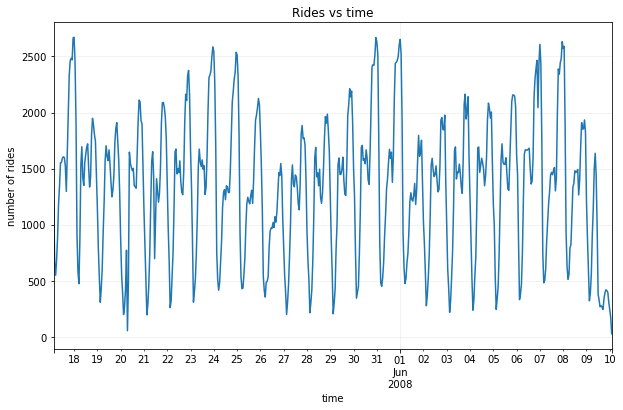

In [8]:
rides_grouped = tdf_traj.groupby(['traj_id']).first()
rides_h_all = visits_per_time_unit(rides_grouped)

rides_h_all['n_visits'].plot(figsize=(10,6))
plt.title("Rides vs time")
plt.xlabel("time")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/timseries_rides.pdf')

### Number of rides per hour of the day (a.k.a. the taxis' circadian rhythm)

Plot the normalized number of trips (total, with/without a passenger) per hour of the day.

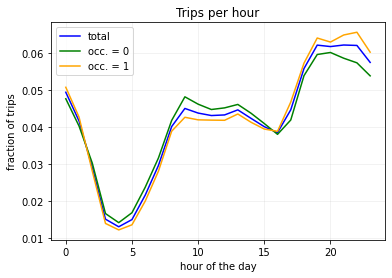

In [9]:
y_tot = list(tdf_rides.groupby("start_hour").count()['traj_id'])
y_tot_norm = np.array(y_tot)/np.array(y_tot).sum()

y_0 = list(tdf_rides_0.groupby("start_hour").count()['traj_id'])
y_0_norm = np.array(y_0)/np.array(y_0).sum()

y_1 = list(tdf_rides_1.groupby("start_hour").count()['traj_id'])
y_1_norm = np.array(y_1)/np.array(y_1).sum()

plt.plot(np.arange(24),y_tot_norm, c='blue', label='total')
plt.plot(np.arange(24),y_0_norm, c='green', label='occ. = 0')
plt.plot(np.arange(24),y_1_norm, c='orange', label='occ. = 1')
plt.legend()
plt.title("Trips per hour")
plt.xlabel("hour of the day")
plt.ylabel("fraction of trips")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/taxis_circadian_rhythm.pdf')

From the figure above we can see how the circadian rhythm of the taxis is characterized by two intervals of high trips demand:
- from 9 a.m. to 3 p.m.
- from 7 p.m. to 12 a.m. <br>
In the first time interval, there is a higher movement of vacant taxis, while from 7 p.m. to 12 a.m., the situation is the opposite.


### Heat Matrix

In [10]:
%%time

date_format = []
for d in tdf_rides_1['start_time']:
    d_ = d.date()
    date_format.append(d_)
    
tdf_rides_1['date_start'] = date_format
data_matrix = tdf_rides_1.groupby(['date_start','start_hour'],as_index=False).count()

##add some zeros for the first and last day in order to cover a span of 24 hours
b = np.array(list([0]*3)+list(data_matrix['uid'])+list([0]*21))
#25 rows (days) and 24 columns (hours)
heat_matrix = b.reshape(25,24)

Wall time: 1.37 s


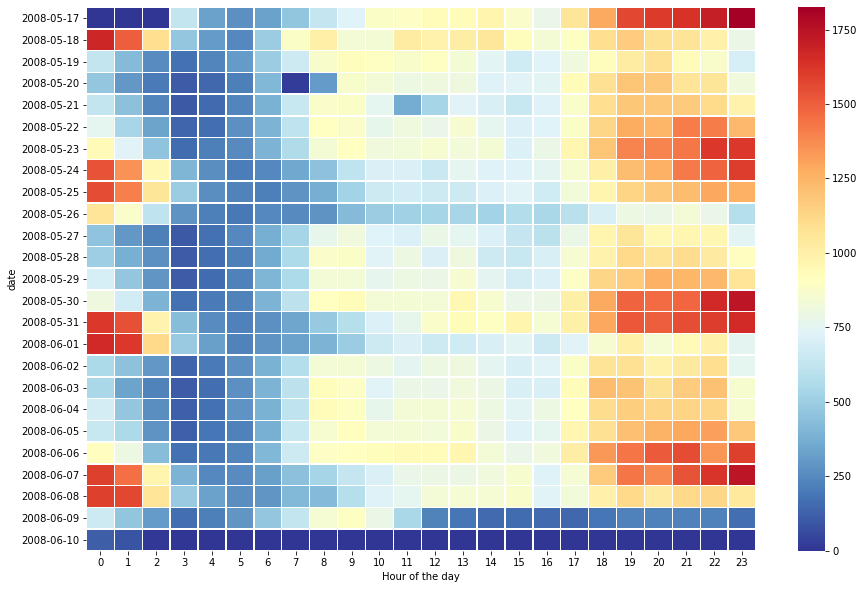

In [11]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(heat_matrix, linewidth=0.5, cmap='RdYlBu_r')
plt.yticks(np.arange(25)+0.5,data_matrix['date_start'].unique(),rotation=0)
plt.ylabel("date")
plt.xlabel("Hour of the day")
plt.savefig('../data/plots/heat_matrix.pdf')
plt.show()

The heat matrix describes the number of trips with a passenger performed per hour for each of the 25 days considered.<br><br>
Note that 05-17 (from 0 a.m. to 2 a.m.) and 06-10 (from 4 a.m. to 11 p.m.) have some missing values since they represent the first and last day in the dataset; therefore, they contain partial information, and when there is no information for an hour we consider 0 trips.<br><br>
We can see how the matrix reports the same findings of the taxis' circadian rhythm. Before 5 a.m. there is the minimum amount of trips, while from 10 a.m. to 3 p.m. it starts to increase and reach its maximum in the evening.<br><br>
It is worth noting how on Friday nights (23-05, 30-05, and 06-06), there is a high demand for taxis, and also on Saturday (17-05, 24-05, 31-05, and 07-06) and Sunday (18-05, 25-05, 01-06, and 08-06) mornings particularly until 3 a.m., reflecting the nightlife of San Francisco.

<a id="sl_dist"></a>
## 3. STRAIGHT LINE DISTANCE


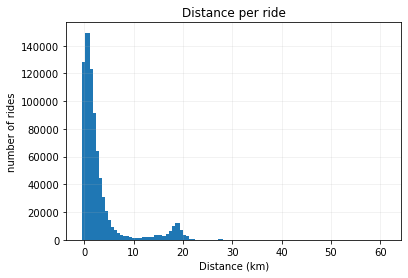

In [12]:
#TOTAL

H, bins = np.histogram(tdf_rides['dist_start_end'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Distance per ride")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.savefig('../data/plots/dist_start_end_tot.pdf')
plt.grid(alpha=0.2)

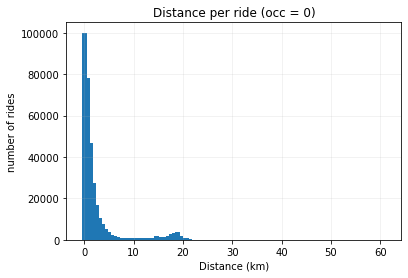

In [13]:
# occ = 0

H, bins = np.histogram(tdf_rides_0['dist_start_end'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Distance per ride (occ = 0)")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/dist_start_end_occ0.pdf')

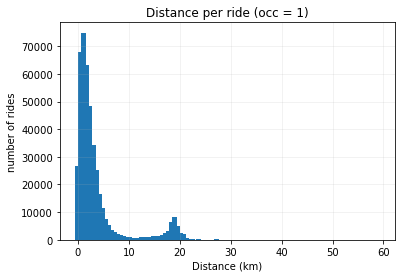

In [14]:
# occ = 1

H, bins = np.histogram(tdf_rides_1['dist_start_end'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Distance per ride (occ = 1)")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/dist_start_end_occ1.pdf')

The peak at $\approx$ 20 km can explainted due to the distance Airport - Downtown.

In [15]:
print("Avg. distance total: " +str(tdf_rides['dist_start_end'].mean())[:5]+" km")
print("Avg. distance occ=0: " +str(tdf_rides_0['dist_start_end'].mean())[:5]+" km")
print("Avg. distance occ=1: " +str(tdf_rides_1['dist_start_end'].mean())[:5]+" km")

Avg. distance total: 3.586 km
Avg. distance occ=0: 2.916 km
Avg. distance occ=1: 4.096 km


Is the difference between the two distributions statistically significant? <br>

Let's perform the Kolmogorov-Smirnov test using a significance level $\alpha=0.5$.

$H_0: P(x)=Q(x)$<br>
$H_1: P(x)\neq Q(x)$

In [16]:
alpha = 0.05

p = tdf_rides_0['dist_start_end'].values
q = tdf_rides_1['dist_start_end'].values

res = kstest(p, q)
print("p-value: "+str(res[1]))

if res[1]<alpha:
    print("Reject H0")
else:
    print("Cannot reject H0")

p-value: 0.0
Reject H0


<a id="cum_dist"></a>
## 4. CUMULATIVE DISTANCE


In [17]:
traveled_km_tot = tdf_rides['cumulative_distance'].sum()
traveled_km_0 = tdf_rides_0['cumulative_distance'].sum()
traveled_km_1 = tdf_rides_1['cumulative_distance'].sum()

print("Distance traveled (tot): {:10.2f}".format(traveled_km_tot)+" km")
print("Distance traveled (occ=0): {:10.2f}".format(traveled_km_0)+" km")
print("Distance traveled (occ=1): {:10.2f}".format(traveled_km_1)+" km")

Distance traveled (tot): 3776539.70 km
Distance traveled (occ=0): 1522750.83 km
Distance traveled (occ=1): 2253788.87 km


During the observation period, the 536 taxis traveled a distance equal to $\approx$ 9.82 times the Moon's average distance to Earth.<br>
The distance traveled with a passenger represents the 59.67% of the total distance.

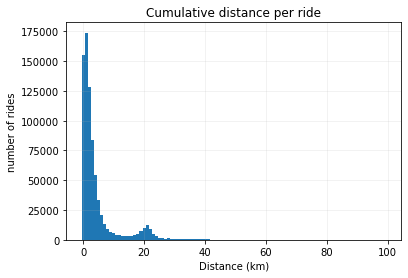

In [18]:
#TOTAL

H, bins = np.histogram(tdf_rides['cumulative_distance'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Cumulative distance per ride")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/cumulative_distance_tot.pdf')

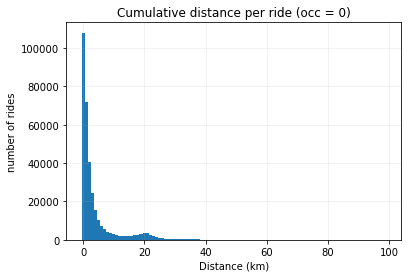

In [19]:
#occupancy = 0

H, bins = np.histogram(tdf_rides_0['cumulative_distance'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Cumulative distance per ride (occ = 0)")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/cumulative_distance_occ0.pdf')

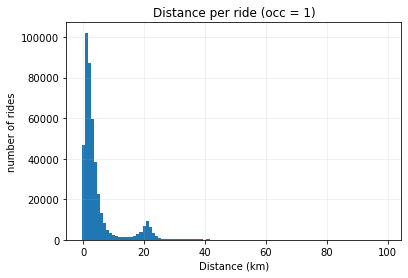

In [20]:
# occ = 1

H, bins = np.histogram(tdf_rides_1['cumulative_distance'], bins=100)
plt.bar(bins[:-1],H,width=1)
plt.title("Distance per ride (occ = 1)")
plt.xlabel("Distance (km)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/cumulative_distance_occ1.pdf')

In [21]:
print("Avg. distance total: " +str(tdf_rides['cumulative_distance'].mean())[:5]+" km")
print("Avg. distance occ=0: " +str(tdf_rides_0['cumulative_distance'].mean())[:5]+" km")
print("Avg. distance occ=1: " +str(tdf_rides_1['cumulative_distance'].mean())[:5]+" km")

Avg. distance total: 4.870 km
Avg. distance occ=0: 4.548 km
Avg. distance occ=1: 5.115 km


Is the difference between the two distributions statistically significant? <br>

Let's perform the Kolmogorov-Smirnov test using a significance level $\alpha=0.5$.

$H_0: P(x)=Q(x)$<br>
$H_1: P(x)\neq Q(x)$

In [22]:
alpha = 0.05

p = tdf_rides_0['cumulative_distance'].values
q = tdf_rides_1['cumulative_distance'].values

res = kstest(p, q)
print("p-value: "+str(res[1]))

if res[1]<alpha:
    print("Reject H0")
else:
    print("Cannot reject H0")

p-value: 0.0
Reject H0


<a id="duration"></a>
## 5. Duration

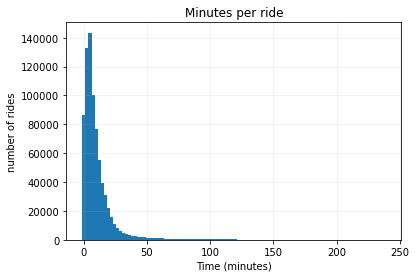

In [23]:
#TOTAL

H, bins = np.histogram(tdf_rides['dt_seconds']/60, bins=100)
plt.bar(bins[:-1],H,width=3)
plt.title("Minutes per ride")
plt.xlabel("Time (minutes)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/minutes_tot.pdf')

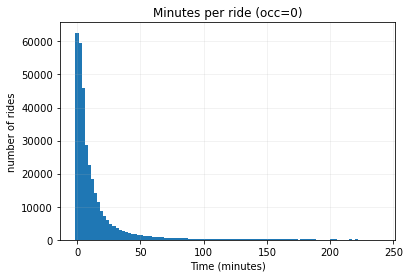

In [24]:
# occ = 0

H, bins = np.histogram(tdf_rides_0['dt_seconds']/60, bins=100)
plt.bar(bins[:-1],H,width=3)
plt.title("Minutes per ride (occ=0)")
plt.xlabel("Time (minutes)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/minutes_occ0.pdf')

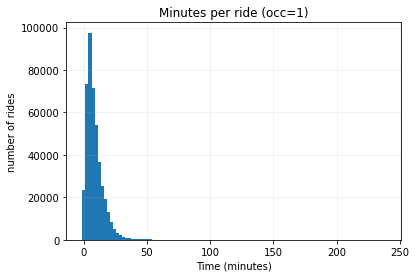

In [25]:
# occ = 1

H, bins = np.histogram(tdf_rides_1['dt_seconds']/60, bins=100)
plt.bar(bins[:-1],H,width=3)
plt.title("Minutes per ride (occ=1)")
plt.xlabel("Time (minutes)")
plt.ylabel("number of rides")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/minutes_occ1.pdf')

In [26]:
print("Avg. minutes total: " +str((tdf_rides['dt_seconds'].mean()/60))[:5]+" minutes")
print("Avg. minutes occ=0: " +str((tdf_rides_0['dt_seconds'].mean()/60))[:5]+" minutes")
print("Avg. minutes occ=1: " +str((tdf_rides_1['dt_seconds'].mean()/60))[:5]+" minutes")

Avg. minutes total: 12.56 minutes
Avg. minutes occ=0: 16.04 minutes
Avg. minutes occ=1: 9.920 minutes


Is the difference between the two distributions statistically significant? <br>

Let's perform the Kolmogorov-Smirnov test using a significance level $\alpha=0.5$.

$H_0: P(x)=Q(x)$<br>
$H_1: P(x)\neq Q(x)$

In [27]:
alpha = 0.05

p = (tdf_rides_0['dt_seconds']/60).values
q = (tdf_rides_1['dt_seconds']/60).values

res = kstest(p, q)
print("p-value: "+str(res[1]))

if res[1]<alpha:
    print("Reject H0")
else:
    print("Cannot reject H0")

p-value: 0.0
Reject H0


<a id="sl_vs_cum"></a>
## 6. STRAIGHT-LINE VS CUMULATIVE

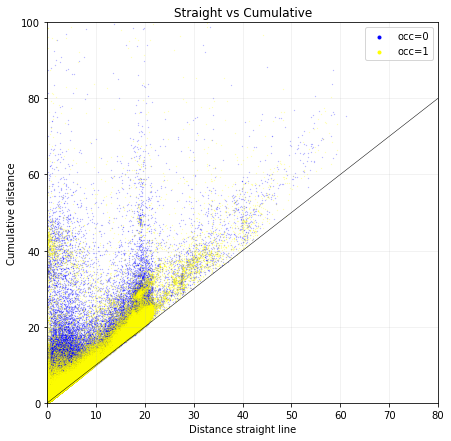

In [28]:
plt.figure(figsize=(7,7))

plt.scatter(tdf_rides_0['dist_start_end'], tdf_rides_0['cumulative_distance'], 
            color='blue', alpha=0.5, marker='.', s=0.2)

plt.scatter(tdf_rides_1['dist_start_end'], tdf_rides_1['cumulative_distance'], 
            color='yellow', alpha=0.5, marker='.', s=0.2)

#create the legend
plt.scatter([-1],[-1], color='blue', marker='.', label='occ=0')
plt.scatter([-1],[-1], color='yellow', marker='.', label='occ=1')

plt.plot(np.arange(100),np.arange(100), color="black", linewidth=0.5)

plt.title("Straight vs Cumulative")
plt.xlabel("Distance straight line")
plt.ylabel("Cumulative distance")
plt.legend()
plt.xlim([0,80])
plt.ylim([0,100])
plt.grid(alpha=0.2)
plt.savefig('../data/plots/straight_vs_cumulative.pdf')

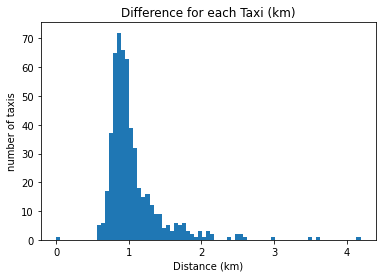

In [29]:
tdf_rides_1['diff_dist'] = tdf_rides_1['cumulative_distance']-tdf_rides_1['dist_start_end']
tdf_rides_1.groupby(['uid'], as_index=False).mean(
).sort_values("diff_dist", ascending=False)[['uid','diff_dist']].hist(bins=75)
plt.grid(alpha=0.2)
plt.title("Difference for each Taxi (km)")
plt.xlabel("Distance (km)")
plt.ylabel("number of taxis")


plt.savefig('../data/plots/distance_diff_taxi.pdf')

In [30]:
#let's look at a ride with a diff_dist \approx 4 km (e.g., traj_id=183)
map_f = tdf_traj[tdf_traj['traj_id']==183].plot_trajectory(hex_color='blue', 
                         start_end_markers=True, max_points=None)

# one with a diff_dist \approx 10 km (e.g., traj_id=661)
map_f=tdf_traj[tdf_traj['traj_id']==661].plot_trajectory(hex_color='orange', 
                         start_end_markers=True, max_points=None, map_f=map_f)

#and one with a diff_dist \approx 20 km (e.g., traj_id=1989)
tdf_traj[tdf_traj['traj_id']==1989].plot_trajectory(hex_color='red', 
                         start_end_markers=True, max_points=None, map_f=map_f)


Note the density of points aligned vertically around 20 km, it represents the distance from the center and the SFO Airport. From the plot seems that taxi driver are honest, since the largest distance differences are generated when the taxi is empty.

<a id="speed"></a>
## 7. SPEED

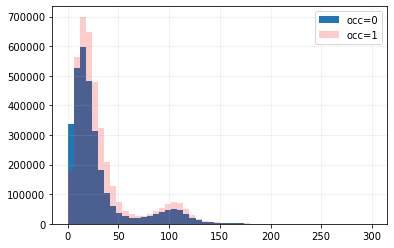

In [31]:
plt.grid(alpha=0.2)
tdf_traj_0['speed_kmh'].hist(bins=50, label="occ=0")
tdf_traj_1['speed_kmh'].hist(bins=50, color='red', alpha=0.2, label="occ=1")
plt.legend()
plt.savefig('../data/plots/speed_distribution.pdf')

In [32]:
print("Avg. speed total: " +str(tdf_traj['speed_kmh'].mean())[:5]+" km/h")
print("Avg. speed occ=0: " +str(tdf_traj_0['speed_kmh'].mean())[:5]+" km/h")
print("Avg. speed occ=1: " +str(tdf_traj_1['speed_kmh'].mean())[:5]+" km/h")

Avg. speed total: 31.66 km/h
Avg. speed occ=0: 29.27 km/h
Avg. speed occ=1: 33.53 km/h


Is the difference between the two distributions statistically significant? <br>

Let's perform the Kolmogorov-Smirnov test using a significance level $\alpha=0.5$.

$H_0: P(x)=Q(x)$<br>
$H_1: P(x)\neq Q(x)$

In [33]:
alpha = 0.05

p = tdf_traj_0['speed_kmh'].values
q = tdf_traj_1['speed_kmh'].values

res = kstest(p, q)
print("p-value: "+str(res[1]))

if res[1]<alpha:
    print("Reject H0")
else:
    print("Cannot reject H0")

p-value: 0.0
Reject H0


<a id="rankings"></a>
## 8. Rankings

The top 10 taxis for total number of rides

In [34]:
tdf_rides_1.groupby(['uid'], as_index=False).count(
).sort_values("dist_start_end", ascending=False)[['uid','occupancy']][:10]

,uid,occupancy
516,upthin,1477
16,acpegho,1351
379,odlorhem,1301
492,udwadla,1245
384,ofikco,1234
204,epabcadu,1233
496,ugatna,1229
173,ejshigib,1226
414,okblahed,1214
366,oblyaga,1212


The top 10 taxis in terms of covered distance (total)

In [35]:
tdf_rides.groupby(['uid'], as_index=False).sum(
).sort_values("cumulative_distance", ascending=False)[['uid','cumulative_distance']][:10]

,uid,cumulative_distance
516,upthin,19484.232164
492,udwadla,13492.276323
2,abdremlu,12518.041703
32,agvexpia,11500.891837
219,etalrab,11344.050587
58,ancorjo,11011.055683
204,epabcadu,10894.217776
409,ojroigna,10878.312730
378,odklobci,10614.743753
114,eapceou,10530.629105


The top 10 taxis in terms of covered distance carrying a passenger

In [36]:
tdf_rides_1.groupby(['uid'], as_index=False).sum(
).sort_values("cumulative_distance", ascending=False)[['uid','cumulative_distance']][:10]

,uid,cumulative_distance
516,upthin,10723.442217
492,udwadla,7551.241722
204,epabcadu,6985.288573
2,abdremlu,6862.535719
219,etalrab,6557.410957
409,ojroigna,6466.126143
402,oivnabyo,6347.087506
32,agvexpia,6267.502542
496,ugatna,6146.870488
58,ancorjo,6063.324809


The top 10 taxis in terms of covered distance when vacant

In [37]:
tdf_rides_0.groupby(['uid'], as_index=False).sum(
).sort_values("cumulative_distance", ascending=False)[['uid','cumulative_distance']][:10]

,uid,cumulative_distance
515,upthin,8760.789947
491,udwadla,5941.034600
2,abdremlu,5655.505984
32,agvexpia,5233.389295
58,ancorjo,4947.730874
114,eapceou,4942.739506
377,odklobci,4918.617658
119,ebdafya,4820.360527
218,etalrab,4786.639630
520,uthiss,4683.468011


The top 10 taxis in terms of average difference between dist-start and cumulative distance when carrying a passenger

In [38]:
tdf_rides_1.groupby(['uid'], as_index=False).mean(
).sort_values("diff_dist", ascending=False)[['uid','diff_dist']][:10]

,uid,diff_dist
516,upthin,4.192623
45,ajtreo,3.591083
33,agyamker,3.504815
89,atsfiv,3.010472
525,utkibedy,2.575992
492,udwadla,2.544413
11,acdiyito,2.518188
161,egreosko,2.511943
247,iatmeuns,2.492661
419,oksbosfl,2.400905


The top 10 fastest taxis (in terms of avg. speed) when carrying a passenger

In [39]:
tdf_traj_1.groupby(['uid'], as_index=False).mean(
).sort_values("speed_kmh", ascending=False)[['uid','speed_kmh']][:10]

,uid,speed_kmh
516,upthin,66.010916
434,onwohyss,58.447863
523,uthsyis,53.715173
45,ajtreo,53.104218
58,ancorjo,52.721450
521,uthiss,52.346389
265,icodmup,51.701366
247,iatmeuns,51.004188
33,agyamker,50.242190
326,ioivkn,49.942215
